In [1]:
import pandas as pd



import re
# Load the original metadata
df = pd.read_csv("classes.csv")  # replace with actual CSV filename

def extract_year(text):
    match = re.search(r"(18|19|20)\d{2}", str(text))
    return int(match.group()) if match else None

# Extract year from either 'description' or 'filename'
df['year'] = df['description'].apply(extract_year)
df['year'] = df['year'].fillna(df['filename'].apply(extract_year))

# Drop rows where year could not be determined
df = df.dropna(subset=['year'])

# Create a new simplified CSV for modeling
df[['filename', 'year']].to_csv("metadata_cleaned.csv", index=False)











In [2]:
import os
import pandas as pd
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
from tqdm import tqdm

# Load your cleaned metadata
df = pd.read_csv("metadata_cleaned.csv")  # this CSV must include 'filename' and 'year'
df = df.sample(1000, random_state=42).reset_index(drop=True)
# Setup pre-trained ResNet model (remove final classification layer)
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()

# Preprocessing pipeline for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Function to extract features
def extract_features(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0)  # add batch dimension
        with torch.no_grad():
            features = resnet(img_tensor).squeeze().numpy()
        return features.flatten()
    except:
        return None

# Create a matrix of features
features = []
valid_rows = []


for _, row in tqdm(df.iterrows(), total=len(df)):
    image_path = os.path.join("archive", row["filename"])
    vec = extract_features(image_path)
    if vec is not None:
        features.append(vec)
        valid_rows.append(row.to_dict())

# Save features and matching metadata
X = np.array(features)
meta = pd.DataFrame(valid_rows)


np.save("features.npy", X)
meta.to_csv("metadata_filtered.csv", index=False)


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|███████████████████████████████████████| 1000/1000 [00:39<00:00, 25.45it/s]


In [3]:
print(features)
print("Feature matrix shape:", X.shape)
print("Filtered metadata size:", len(meta))


[array([0.51166946, 0.63250536, 0.20995274, ..., 0.11395825, 0.        ,
       0.02187021], dtype=float32), array([0.00690067, 0.28717667, 0.03189135, ..., 0.32921204, 0.13262041,
       0.26878506], dtype=float32), array([2.4117170e-02, 9.7117162e-01, 5.0172508e-02, ..., 2.2752520e-04,
       1.5597470e-01, 2.8290936e-01], dtype=float32), array([0.09674474, 0.4416438 , 0.0320465 , ..., 0.6128355 , 0.71230876,
       0.03669438], dtype=float32), array([0.09302708, 0.11045329, 0.04692397, ..., 1.4241078 , 0.2046761 ,
       0.00814772], dtype=float32), array([0.00888783, 0.38132983, 0.60792464, ..., 0.27363002, 0.03237596,
       0.12559597], dtype=float32), array([0.06554123, 1.0594984 , 0.00689822, ..., 0.24322759, 0.04624879,
       0.29362205], dtype=float32), array([0.19455612, 0.3020091 , 0.06476738, ..., 0.        , 0.01411579,
       0.19688372], dtype=float32), array([0.36720923, 0.27703533, 0.00505005, ..., 0.8020152 , 0.08679574,
       0.23008956], dtype=float32), array([0.

In [4]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

# Load features and metadata
features = np.load("features.npy")
meta = pd.read_csv("metadata_filtered.csv")
years = meta['year'].values

# Clean invalid values if needed
features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)

# Compute cosine similarity
sim_matrix = cosine_similarity(features)

# Build creativity implication graph
def build_graph(sim_matrix, years, alpha=0.5):
    G = nx.DiGraph()
    n = len(years)
    for i in range(n):
        for j in range(n):
            if years[i] < years[j]:  # i is earlier, j is later
                weight = sim_matrix[i][j]
                score = alpha - weight
                G.add_edge(j, i, weight=max(score, 0))  # reverse edge for originality
    return G

G = build_graph(sim_matrix, years)

# Save graph for reuse
import networkx as nx
import pickle

# Save manually with pickle (exact same format)
with open("creativity_graph.gpickle", "wb") as f:
    pickle.dump(G, f)
    
print("Saved creativity_graph.gpickle")

Saved creativity_graph.gpickle


In [5]:
with open("creativity_graph.gpickle", "rb") as f:
    G = pickle.load(f)

In [6]:
import numpy as np
import pandas as pd

# Compute creativity scores from graph
def compute_creativity_scores(G, alpha=0.85, max_iter=100):
    nodes = list(G.nodes())
    N = len(nodes)
    scores = np.ones(N) / N
    A = nx.to_numpy_array(G, nodelist=nodes)

    row_sums = A.sum(axis=1)
    row_sums[row_sums == 0] = 1
    A = A / row_sums[:, np.newaxis]

    for _ in range(max_iter):
        scores = alpha * A.T @ scores + (1 - alpha) / N

    return dict(zip(nodes, scores))

# Compute
creativity_scores = compute_creativity_scores(G)

# Load metadata and map scores
meta = pd.read_csv("metadata_filtered.csv").reset_index(drop=True)
meta['creativity_score'] = meta.index.map(creativity_scores)

# Save results
meta.to_csv("creativity_ranked.csv", index=False)
print(" Saved creativity_ranked.csv with creativity scores.")

 Saved creativity_ranked.csv with creativity scores.


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the ranked data
df = pd.read_csv("creativity_ranked.csv")

# Sort by creativity
df_sorted = df.sort_values(by="creativity_score", ascending=False)

print(df_sorted[['filename', 'year', 'creativity_score']].head(10))

                                              filename    year  \
6    Romanticism/eugene-delacroix_summer-diana-surp...  1822.0   
336  Romanticism/rudolf-von-alt_altausseersee-with-...  1839.0   
652  Post_Impressionism/vincent-van-gogh_park-at-as...  1887.0   
145  Post_Impressionism/vincent-van-gogh_the-seine-...  1887.0   
207  Ukiyo_e/keisai-eisen_no-2-from-the-series-mode...  1835.0   
154  Romanticism/john-constable_east-bergholt-recto...  1810.0   
585  Impressionism/camille-pissarro_near-sydenham-h...  1871.0   
165  Romanticism/gheorghe-tattarescu_portrait-of-ni...  1851.0   
129  Symbolism/ferdinand-hodler_lake-thun-from-the-...  1906.0   
686  Ukiyo_e/keisai-eisen_no-2-ni-from-the-series-p...  1835.0   

     creativity_score  
6            0.023382  
336          0.017781  
652          0.013951  
145          0.012045  
207          0.011623  
154          0.010586  
585          0.009831  
165          0.008694  
129          0.008640  
686          0.008612  


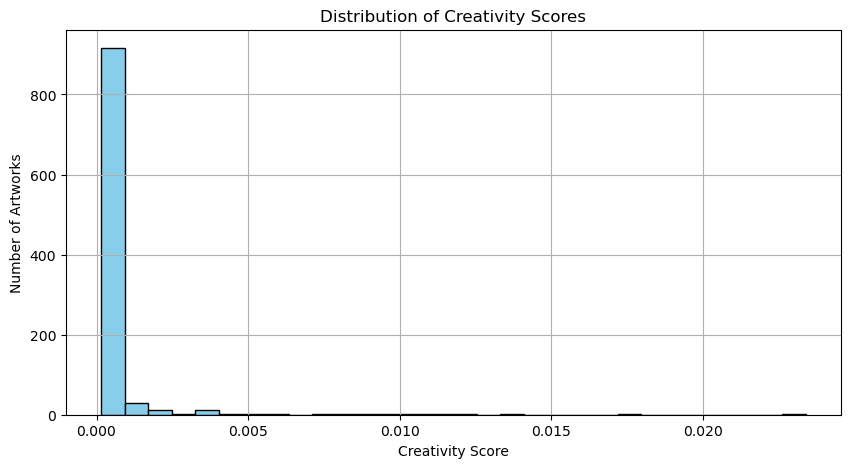

In [8]:
plt.figure(figsize=(10, 5))
plt.hist(df['creativity_score'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Creativity Scores")
plt.xlabel("Creativity Score")
plt.ylabel("Number of Artworks")
plt.grid(True)
plt.show()

In [9]:
# Example: most creative artists on average
if 'artist' in df.columns:
    top_artists = df.groupby('artist')['creativity_score'].mean().sort_values(ascending=False).head(10)
    print(top_artists)

In [10]:
top_files = df_sorted['filename'].head(10).tolist()
print("Most creative artworks:")
for f in top_files:
    print(f)

Most creative artworks:
Romanticism/eugene-delacroix_summer-diana-surprised-at-her-bath-by-actaeon-1822(1).jpg
Romanticism/rudolf-von-alt_altausseersee-with-trisselwand-1839.jpg
Post_Impressionism/vincent-van-gogh_park-at-asnieres-in-spring-1887.jpg
Post_Impressionism/vincent-van-gogh_the-seine-with-the-pont-de-clichy-1887.jpg
Ukiyo_e/keisai-eisen_no-2-from-the-series-modern-versions-of-the-five-women-t-sei-gonin-onna-1835.jpg
Romanticism/john-constable_east-bergholt-rectory-1810.jpg
Impressionism/camille-pissarro_near-sydenham-hill-looking-towards-lower-norwood-1871.jpg
Romanticism/gheorghe-tattarescu_portrait-of-nicolae-b-lcescu-1851.jpg
Symbolism/ferdinand-hodler_lake-thun-from-the-path-to-the-plate-schynigen-1906.jpg
Ukiyo_e/keisai-eisen_no-2-ni-from-the-series-popular-indigo-clothing-ryuko-ai-shitate-1835(1).jpg


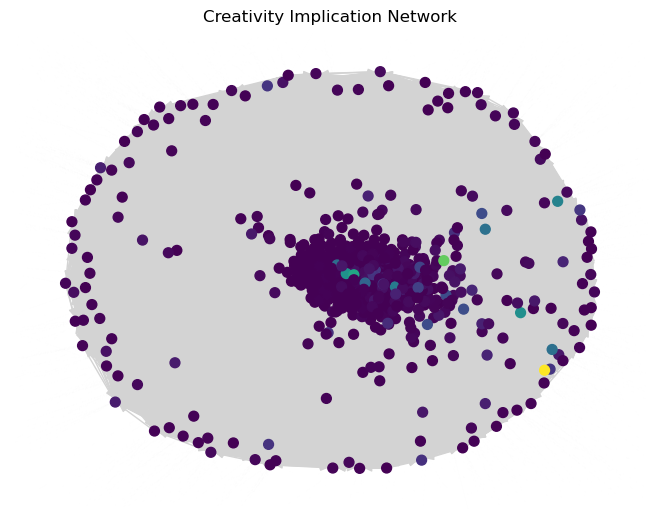

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

node_colors = [creativity_scores[n] for n in G.nodes()]
nx.draw_spring(G, node_color=node_colors, cmap='viridis', node_size=50, edge_color='lightgray')
plt.title("Creativity Implication Network")
plt.show()

In [12]:

df = pd.read_csv("creativity_ranked.csv")

# Pick the top-scoring artwork
top_idx = df['creativity_score'].idxmax()
print("Original entry:")
print(df.loc[top_idx])

Original entry:
filename            Romanticism/eugene-delacroix_summer-diana-surp...
year                                                           1822.0
creativity_score                                             0.023382
Name: 6, dtype: object


In [13]:
# Save original year for comparison
original_year = df.loc[top_idx, 'year']

df.loc[top_idx, 'year'] = original_year - 50

# Save new modified metadata
df.to_csv("metadata_time_travel.csv", index=False)
print(f"Time Machine: shifted artwork from {original_year} to {original_year - 50}")

Time Machine: shifted artwork from 1822.0 to 1772.0


In [14]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import pickle

# === Step 1: Load features and new metadata ===
features = np.load("features.npy")
meta = pd.read_csv("metadata_time_travel.csv")
years = meta['year'].values

# Clean invalid values
features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)

# === Step 2: Compute cosine similarity ===
sim_matrix = cosine_similarity(features)

# === Step 3: Build updated creativity graph ===
def build_graph(sim_matrix, years, alpha=0.5):
    G = nx.DiGraph()
    n = len(years)
    for i in range(n):
        for j in range(n):
            if years[i] < years[j]:
                weight = sim_matrix[i][j]
                score = alpha - weight
                G.add_edge(j, i, weight=max(score, 0))
    return G

G = build_graph(sim_matrix, years)

#  save new graph
with open("creativity_graph_time_machine.gpickle", "wb") as f:
    pickle.dump(G, f)

# === Step 4: Compute creativity scores again ===
def compute_creativity_scores(G, alpha=0.85, max_iter=100):
    nodes = list(G.nodes())
    N = len(nodes)
    scores = np.ones(N) / N
    A = nx.to_numpy_array(G, nodelist=nodes)
    row_sums = A.sum(axis=1)
    row_sums[row_sums == 0] = 1
    A = A / row_sums[:, np.newaxis]
    for _ in range(max_iter):
        scores = alpha * A.T @ scores + (1 - alpha) / N
    return dict(zip(nodes, scores))

creativity_scores = compute_creativity_scores(G)

# === Step 5: Save updated rankings ===
meta = meta.reset_index(drop=True)
meta['creativity_score'] = meta.index.map(creativity_scores)
meta.to_csv("creativity_ranked_time_machine.csv", index=False)

print("Time Machine simulation complete. Results saved to creativity_ranked_time_machine.csv")

Time Machine simulation complete. Results saved to creativity_ranked_time_machine.csv


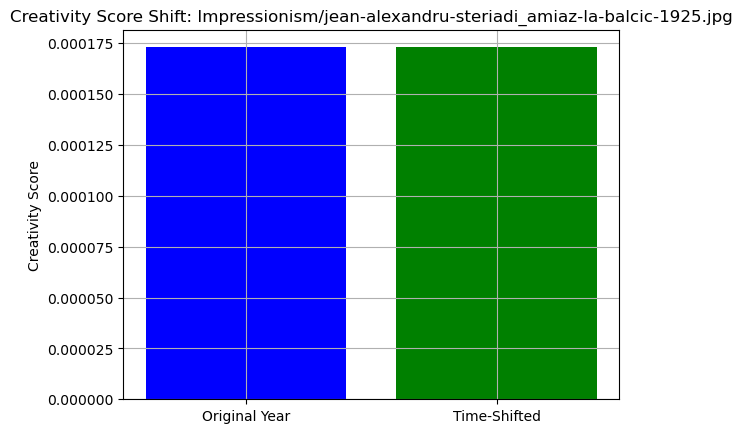

Artwork: Impressionism/jean-alexandru-steriadi_amiaz-la-balcic-1925.jpg
Creativity Score Before: 0.0002
Creativity Score After:  0.0002
Rank went from 791 to 791


In [15]:
import matplotlib.pyplot as plt

# Load original and time-machine versions
original = pd.read_csv("creativity_ranked.csv")
shifted = pd.read_csv("creativity_ranked_time_machine.csv")

# Find the artwork that was moved (same filename)
common_files = set(original['filename']) & set(shifted['filename'])
delta = []

for f in common_files:
    score_orig = original.loc[original['filename'] == f, 'creativity_score'].values[0]
    score_shift = shifted.loc[shifted['filename'] == f, 'creativity_score'].values[0]
    delta.append((f, score_orig, score_shift))

# Sort by largest increase
delta_sorted = sorted(delta, key=lambda x: x[2] - x[1], reverse=True)
top_change = delta_sorted[0]

filename, score_before, score_after = top_change

# Plot
plt.bar(["Original Year", "Time-Shifted"], [score_before, score_after], color=["blue", "green"])
plt.title(f"Creativity Score Shift: {filename}")
plt.ylabel("Creativity Score")
plt.grid(True)
plt.show()

# Rank change
orig_rank = original.sort_values("creativity_score", ascending=False).reset_index().loc[original['filename'] == filename].index[0] + 1
new_rank = shifted.sort_values("creativity_score", ascending=False).reset_index().loc[shifted['filename'] == filename].index[0] + 1

print(f"Artwork: {filename}")
print(f"Creativity Score Before: {score_before:.4f}")
print(f"Creativity Score After:  {score_after:.4f}")
print(f"Rank went from {orig_rank} to {new_rank}")

In [16]:

# Load original metadata
df = pd.read_csv("creativity_ranked.csv")

# Find most and least creative paintings
most_creative_idx = df['creativity_score'].idxmax()
least_creative_idx = df['creativity_score'].idxmin()

# Store original years
most_year = df.loc[most_creative_idx, 'year']
least_year = df.loc[least_creative_idx, 'year']

# Apply time shifts
df.loc[most_creative_idx, 'year'] = most_year - 100
df.loc[least_creative_idx, 'year'] = least_year + 100

# Save new version
df.to_csv("metadata_time_travel_dual.csv", index=False)

print(f" Shifted most creative from {most_year} → {most_year - 100}")
print(f" Shifted least creative from {least_year} → {least_year + 100}")

 Shifted most creative from 1822.0 → 1722.0
 Shifted least creative from 2001.0 → 2101.0


In [17]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import pickle

# === Load features and new metadata ===
features = np.load("features.npy")
meta = pd.read_csv("metadata_time_travel_dual.csv")
years = meta['year'].values

# Clean invalid values
features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)

# === Compute cosine similarity ===
sim_matrix = cosine_similarity(features)

# === Build creativity graph ===
def build_graph(sim_matrix, years, alpha=0.5):
    G = nx.DiGraph()
    n = len(years)
    for i in range(n):
        for j in range(n):
            if years[i] < years[j]:
                weight = sim_matrix[i][j]
                score = alpha - weight
                G.add_edge(j, i, weight=max(score, 0))
    return G

G = build_graph(sim_matrix, years)

# Save new graph
with open("creativity_graph_time_travel_dual.gpickle", "wb") as f:
    pickle.dump(G, f)

# === Compute creativity scores again ===
def compute_creativity_scores(G, alpha=0.85, max_iter=100):
    nodes = list(G.nodes())
    N = len(nodes)
    scores = np.ones(N) / N
    A = nx.to_numpy_array(G, nodelist=nodes)
    row_sums = A.sum(axis=1)
    row_sums[row_sums == 0] = 1
    A = A / row_sums[:, np.newaxis]
    for _ in range(max_iter):
        scores = alpha * A.T @ scores + (1 - alpha) / N
    return dict(zip(nodes, scores))

creativity_scores = compute_creativity_scores(G)

# === Save new rankings ===
meta = meta.reset_index(drop=True)
meta['creativity_score'] = meta.index.map(creativity_scores)
meta.to_csv("creativity_ranked_time_travel_dual.csv", index=False)

print(" Time Travelers simulation complete — saved to creativity_ranked_time_travel_dual.csv")

 Time Travelers simulation complete — saved to creativity_ranked_time_travel_dual.csv


 Most Creative Painting: Romanticism/eugene-delacroix_summer-diana-surprised-at-her-bath-by-actaeon-1822(1).jpg
Score Before: 0.0234, Rank Before: 7
Score After:  0.0234, Rank After:  7

 Least Creative Painting: Abstract_Expressionism/dan-christensen_swing-street-2001.jpg
Score Before: 0.0002, Rank Before: 16
Score After:  0.0002, Rank After:  16


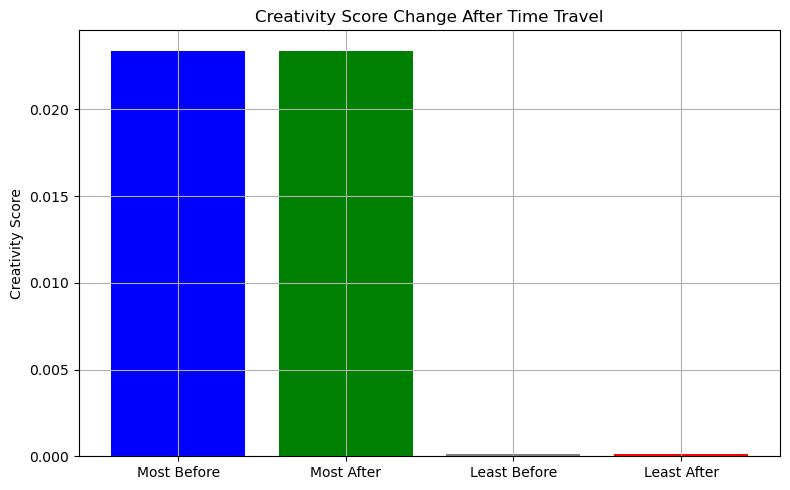

In [18]:
import matplotlib.pyplot as plt

# Load both original and shifted data
original = pd.read_csv("creativity_ranked.csv")
shifted = pd.read_csv("creativity_ranked_time_travel_dual.csv")

# Identify most and least creative paintings BEFORE shift
most_creative = original.loc[original['creativity_score'].idxmax()]
least_creative = original.loc[original['creativity_score'].idxmin()]

# Extract their filenames
most_filename = most_creative['filename']
least_filename = least_creative['filename']

# Lookup new scores
most_new_score = shifted.loc[shifted['filename'] == most_filename, 'creativity_score'].values[0]
least_new_score = shifted.loc[shifted['filename'] == least_filename, 'creativity_score'].values[0]

# Get ranks before and after
def get_rank(df, filename):
    return df.sort_values("creativity_score", ascending=False).reset_index(drop=True).index[df['filename'] == filename][0] + 1

# Ranks
most_old_rank = get_rank(original, most_filename)
most_new_rank = get_rank(shifted, most_filename)

least_old_rank = get_rank(original, least_filename)
least_new_rank = get_rank(shifted, least_filename)

# Display results
print(f" Most Creative Painting: {most_filename}")
print(f"Score Before: {most_creative['creativity_score']:.4f}, Rank Before: {most_old_rank}")
print(f"Score After:  {most_new_score:.4f}, Rank After:  {most_new_rank}")
print()

print(f" Least Creative Painting: {least_filename}")
print(f"Score Before: {least_creative['creativity_score']:.4f}, Rank Before: {least_old_rank}")
print(f"Score After:  {least_new_score:.4f}, Rank After:  {least_new_rank}")

#  bar plot of change
plt.figure(figsize=(8, 5))
plt.bar(["Most Before", "Most After", "Least Before", "Least After"],
        [most_creative['creativity_score'], most_new_score, least_creative['creativity_score'], least_new_score],
        color=["blue", "green", "gray", "red"])
plt.ylabel("Creativity Score")
plt.title("Creativity Score Change After Time Travel")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
#### New Implementation

In [20]:
print(meta.columns)

Index(['filename', 'year', 'creativity_score'], dtype='object')


In [21]:
pip install sentence_transformers


Note: you may need to restart the kernel to use updated packages.


In [22]:
from sentence_transformers import SentenceTransformer

# === Load visual features and metadata ===
meta = pd.read_csv("metadata_filtered.csv")
image_features = np.load("features.npy")

# === Encode filenames using Sentence-BERT ===
model = SentenceTransformer("all-MiniLM-L6-v2")
titles = meta['filename'].fillna("").tolist()
title_embeddings = model.encode(titles, convert_to_numpy=True)

# === Normalize both sets of features ===
image_features = image_features / np.linalg.norm(image_features, axis=1, keepdims=True)
title_embeddings = title_embeddings / np.linalg.norm(title_embeddings, axis=1, keepdims=True)

# === Concatenate visual and textual features ===
fused_features = np.hstack([image_features, title_embeddings])
print("Fused features shape:", fused_features.shape)

# === Save for later use ===
np.save("features_fused.npy", fused_features)

Fused features shape: (988, 2432)


In [23]:


# === Load fused features and metadata ===
features = np.load("features_fused.npy")
meta = pd.read_csv("metadata_filtered.csv")
years = meta['year'].values

# === Compute cosine similarity ===
sim_matrix = cosine_similarity(features)

# === Build creativity implication graph ===
def build_graph(sim_matrix, years, alpha=0.5):
    G = nx.DiGraph()
    n = len(years)
    for i in range(n):
        for j in range(n):
            if years[i] < years[j]:
                weight = sim_matrix[i][j]
                score = alpha - weight
                G.add_edge(j, i, weight=max(score, 0))
    return G

G = build_graph(sim_matrix, years)

with open("creativity_graph_fused.gpickle", "wb") as f:
    pickle.dump(G, f)

# === Compute creativity scores ===
def compute_creativity_scores(G, alpha=0.85, max_iter=100):
    nodes = list(G.nodes())
    N = len(nodes)
    scores = np.ones(N) / N
    A = nx.to_numpy_array(G, nodelist=nodes)
    row_sums = A.sum(axis=1)
    row_sums[row_sums == 0] = 1
    A = A / row_sums[:, np.newaxis]
    for _ in range(max_iter):
        scores = alpha * A.T @ scores + (1 - alpha) / N
    return dict(zip(nodes, scores))

creativity_scores = compute_creativity_scores(G)

# === Save updated rankings ===
meta = meta.reset_index(drop=True)
meta['creativity_score'] = meta.index.map(creativity_scores)
meta.to_csv("creativity_ranked_fused.csv", index=False)

print(" Saved fused creativity rankings to creativity_ranked_fused.csv")

 Saved fused creativity rankings to creativity_ranked_fused.csv


In [ ]:

from sklearn.manifold import TSNE

# Load fused features and creativity scores
features = np.load("features_fused.npy")
meta = pd.read_csv("creativity_ranked_fused.csv")

# Apply t-SNE (or PCA for faster test)
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42)
tsne_results = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
                      c=meta['creativity_score'], cmap='viridis', s=30)
plt.colorbar(scatter, label="Creativity Score")
plt.title("2D Visualization of Artworks (Fused Features + t-SNE)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os

meta = pd.read_csv("creativity_ranked_fused.csv")

top = meta.sort_values("creativity_score", ascending=False).head(10)

plt.figure(figsize=(15, 6))
for i, row in enumerate(top.itertuples()):
    img_path = os.path.join("archive", row.filename)
    try:
        img = Image.open(img_path).convert("RGB")
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"{row.creativity_score:.3f}", fontsize=10)
        plt.axis("off")
    except Exception as e:
        print(f"⚠️ Could not load: {img_path} → {e}")

plt.suptitle("Top 10 Most Creative Artworks", fontsize=16)
plt.tight_layout()
plt.show()